# Predicting the Helpfulness of Amazon Reviews - Clothing, Shoes, and Jewelry Category

## Import Libraries

In [1]:
# load packages
import gzip
import json
import os
import wget

import random
import string

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
# this nltk download may be needed. download stopwords, punkt
# nltk.download()

import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and Prepare Dataset

In [2]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Clothing_Shoes_and_Jewelry_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [3]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)

In [4]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

## Exploratory Data Analysis

### Data Insights

In [5]:
# take a look at the shape of the data
df.shape

(278677, 12)

In [6]:
# take a look at a sample of rows
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
12669,A3CKLLCH0MDTGH,B0007YR8WW,cookie1123,"[0, 0]","I accidentally ordered the wrong size, my bad....",3.0,Not adjustable,1400198400,"05 16, 2014",0,0,0.000000
99759,A19EKT8H85AKO5,B003AU5WBE,BigStory,"[95, 97]",I really like these long sleeve cotton shirts ...,5.0,Nice versatile shirt 100% cotton,1277164800,"06 22, 2010",95,97,0.979381
91882,A3UE6JAMSEZM9X,B002XZMCQ0,Smilingmoon,"[0, 0]",My favorites are the Capezio high rise tights....,5.0,Good,1354665600,"12 5, 2012",0,0,0.000000
189636,A1D7A6K94CWAXC,B007JNFLEG,"Jo Maree ""Jo Maree""","[1, 1]",so happy to order a wide width 8C - truly love...,5.0,"Justin Boots Women's Classic Western Boot,Tan ...",1362787200,"03 9, 2013",1,1,1.000000
155090,AX6PXAM56VVNJ,B005DO1CLE,Woofie,"[28, 30]","I bought the Dansko Volley, and thought the Va...",3.0,Very cute...but narrow at vamp....,1332806400,"03 27, 2012",28,30,0.933333


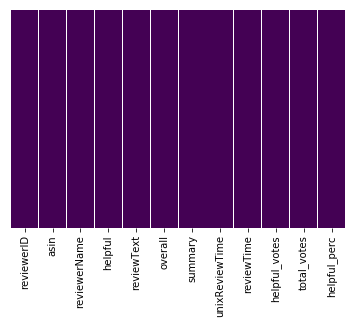

In [7]:
# see if there are any missing values by feature
# missing values show up in yellow
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [8]:
# calculate how many values are missing by feature
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,452
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


### Summary Statistics

In [9]:
# take a look at summary statistics of dataset
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,278677.000000,2.786770e+05,278677.000000,278677.00000,278677.000000
mean,4.245133,1.374197e+09,1.145936,1.34460,0.243571
std,1.103747,2.904510e+07,6.579834,7.05004,0.410156
min,1.000000,1.048896e+09,0.000000,0.00000,0.000000
25%,4.000000,1.362787e+09,0.000000,0.00000,0.000000
50%,5.000000,1.382141e+09,0.000000,0.00000,0.000000
75%,5.000000,1.393200e+09,1.000000,1.00000,0.500000
max,5.000000,1.406074e+09,1200.000000,1267.00000,2.000000


### Examining the Target Variable

Text(0.5,1,'Histogram of Helpful Percentages')

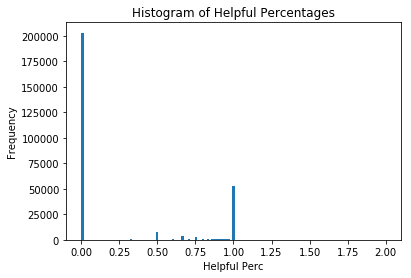

In [10]:
# look at distribution of helpful_perc
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

### Data Cleaning

In [11]:
# subset df of reviews that have at least three votes
df_three = df[df.total_votes >= 3]

# subset df of reviews that have two both and both are in agreeement
df_two = df[((df.total_votes == 2) & (df.helpful_perc == 1)) | ((df.total_votes == 2) & (df.helpful_perc == 0))]

# combine the dfs back together
df = df_three.append(df_two, ignore_index=True)
df.shape

(41057, 12)

In [12]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,41057.000000,4.105700e+04,41057.000000,41057.000000,41057.000000
mean,4.015393,1.351621e+09,6.895292,7.848308,0.849833
std,1.300165,4.210885e+07,15.948431,16.924785,0.241935
min,1.000000,1.048896e+09,0.000000,2.000000,0.000000
25%,3.000000,1.335744e+09,2.000000,3.000000,0.750000
50%,5.000000,1.362269e+09,3.000000,4.000000,1.000000
75%,5.000000,1.380758e+09,6.000000,7.000000,1.000000
max,5.000000,1.405642e+09,1200.000000,1267.000000,1.000000


Text(0.5,1,'Histogram of Helpful Percentages')

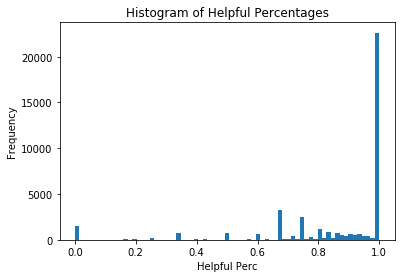

In [13]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Model 1: Helpful Reviews Are Determined Randomly

In [14]:
# calculate total number of reviews
total_reviews = len(df)

# to repeat results
random.seed(12345)

helpful_perc = df['helpful_perc']

random_helpful = []
for i in range(total_reviews):
    random_helpful.append(random.random())
    

np.corrcoef(helpful_perc, random_helpful)[1,0]

0.003217045129200945

## Model 2: Naive Bayes Bag of Words Model

### Data Pre-Processing

In [15]:
# ensure there are no missing values in the review or summary text or the overall helpullness percentage
len(df) == len(df.dropna(subset=['reviewText', 'summary', 'helpful_perc']))

True

In [16]:
# Combine the reviewText and summary text fields to combine into a single "document" with which to analyze

stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in word_tokenize(text) if not word in stop_words]

In [17]:
# We should then tokenize and stem the review data before ingesting into our NLP models
df['combinedText'] = df['summary'].str.lower() + ". " +  df['reviewText'].str.lower()

# Now tokenize these and remove stop words
df['processedText'] = df['combinedText'].apply(tokenize)

In [18]:
# preprocess the data
data = df[['combinedText', 'helpful_perc']]

le = preprocessing.LabelEncoder()
preprocessed_data = data.apply(le.fit_transform)

### Split into Train/Test

In [19]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(preprocessed_data['combinedText'], 
                                                    preprocessed_data['helpful_perc'],
                                                    random_state = 12345, # reproduce results
                                                    test_size=0.2)

### Instantiate and Train the Model

In [20]:
# instantiate model
regr = linear_model.LinearRegression()

# train the model using the training sets
regr.fit(np.array(Train_X.values.tolist()).reshape(-1, 1), Train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Predict Test Labels and Score

In [21]:
# predict values
pred = regr.predict(np.array(Test_X.values.tolist()).reshape(-1, 1))

# score with correlation coefficient
np.corrcoef(Test_Y,pred)[1,0]

0.03439855414320746

## Model 3: TF-IDF and Linear Regression

### Split Into Train/Test

In [22]:
# split into train//test sets
data = df[['combinedText', 'helpful_perc']]

df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 12345)

### Data Pre-Processing

In [23]:
# stem combinedText to reduce size of corpus
porter=PorterStemmer()

def stem_text(df):
    text_list = df['combinedText'].tolist()
    text_list_stem = [None] * len(text_list)

    for i in range(len(text_list)):
        text_list_stem[i] = ' '.join([porter.stem(w) for w in text_list[i].split()])
    
    return text_list_stem

text_list_stem = stem_text(data)

In [24]:
# vectorize text
vectorizer = TfidfVectorizer(
                max_features=100,
                ngram_range=(1,1)
                )

vectorizer.fit_transform(text_list_stem).toarray()

array([[0.        , 0.        , 0.13016789, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16275856, 0.        , ..., 0.        , 0.        ,
        0.05644013],
       [0.        , 0.07899212, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04034558, ..., 0.        , 0.13650134,
        0.04853925],
       [0.        , 0.        , 0.15797028, ..., 0.        , 0.        ,
        0.        ]])

In [25]:
# vectorize train dataset
train_text_stem = stem_text(df_train)
train_vectorized = vectorizer.transform(train_text_stem).toarray()

print('Shape:', train_vectorized.shape)

Shape: (32845, 100)


In [26]:
# vectorize test dataset
test_text_stem = stem_text(df_test)
test_vectorized = vectorizer.transform(test_text_stem).toarray()

print('Shape:', test_vectorized.shape)

Shape: (8212, 100)


In [27]:
# create array of labels to use in linear regression
df_train_labels = np.array(df_train['helpful_perc'])
df_test_labels = np.array(df_test['helpful_perc'])

### Instantiate and Train the Model

In [28]:
# instantiate model
regr_2 = linear_model.LinearRegression()

# train the model using the training sets
regr_2.fit(np.array(train_vectorized.tolist()), df_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Predict Test Labels and Score

In [29]:
# predict values
pred_2 = regr_2.predict(np.array(test_vectorized.tolist()))

# score with correlation coefficient
np.corrcoef(df_test_labels, pred_2)[1,0]

0.25713801782246565

## Model 4: BERT